In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/03_adaptiveCA')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn.functional as F
from torchvision import models

import PIL.Image, PIL.ImageDraw
from skimage.color import rgba2rgb
import cv2
from IPython.display import Image, clear_output, display
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from models.minimalNCA import CA

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# vgg19 = models.vgg19(weights='IMAGENET1K_V1').features.cuda()
vgg19 = models.vgg16(weights='IMAGENET1K_V1').features.cuda()

import io
import PIL 

def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1)*255)
    return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()

def imshow(a, fmt='jpeg', id=None):
    return display(Image(data=imencode(a, fmt)), display_id=id)

def grab_plot(close=True):
    """Return the current Matplotlib figure as an image"""
    fig = plt.gcf()
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer._renderer)
    a = np.float32(img[..., 3:]/255.0)
    img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
    if close:
        plt.close()
    return img

C:\Users\Heysoos\AppData\Local\Temp\ipykernel_25172\4078066545.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.resize((128, 128), PIL.Image.ANTIALIAS)


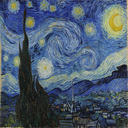

In [3]:
# content image
# target_file = 'cover_vers2.jpg'
# target_file = 'checkerboard.jpg'
# target_file = 'pug.png'
# target_file = 'dotted_0201.jpg'
target_file = 'starry.jpg'
img = PIL.Image.open('../targets/' + target_file)
shape = np.array(img).shape
aspectratio = shape[0] / shape[1]

#show img thumbnail
img.resize((128, 128), PIL.Image.ANTIALIAS)

In [4]:
RES=128 # resolution of grid
CHANNELS=12 # number of channels in grid
HIDDEN=96 # number of hidden neurons

ca_train = CA(CHANNELS=CHANNELS, HIDDEN=HIDDEN).cuda()
ca_train.initGrid(BS=1, RES=RES)

pool = ca_train.seed(n=256, RES=RES)

optim = torch.optim.Adam(ca_train.parameters(), lr=1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(optim, [1000, 2000], 0.3)

In [5]:
'''
This loss is used in place of the Gramm Matrix loss previously used.

Sliced Wasserstein Optimal Flow Loss
http://openaccess.thecvf.com/content/CVPR2021/papers/Heitz_A_Sliced_Wasserstein_Loss_for_Neural_Texture_Synthesis_CVPR_2021_paper.pdf
https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_pytorch.ipynb#scrollTo=vFqmv9w5tPQB
'''

def calc_styles_vgg(imgs):
  style_layers = [1, 6, 11, 18, 25]  
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None].cuda()
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None].cuda()
  x = (imgs-mean) / std
  b, c, h, w = x.shape
  features = [x.reshape(b, c, h*w)]
  for i, layer in enumerate(vgg19[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      b, c, h, w = x.shape
      features.append(x.reshape(b, c, h*w))
  return features

def project_sort(x, proj):
    return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]


def ot_loss(source, target, proj_n=32):
    ch, n = source.shape[-2:]
    projs = F.normalize(torch.randn(ch, proj_n), dim=0).cuda()
    source_proj = project_sort(source, projs)
    target_proj = project_sort(target, projs)
    target_interp = F.interpolate(target_proj, n, mode='nearest')
    return (source_proj-target_interp).square().sum()

def create_vgg_loss(target_img):
  yy = calc_styles_vgg(target_img)
  def loss_f(imgs):
    xx = calc_styles_vgg(imgs)
    return sum(ot_loss(x, y) for x, y in zip(xx, yy))
  return loss_f

def to_rgb(x):
  return x[...,:3,:,:]+0.5

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

def overflow_loss(x):
    return (x-x.clamp(-1.0, 1.0)).abs().sum()

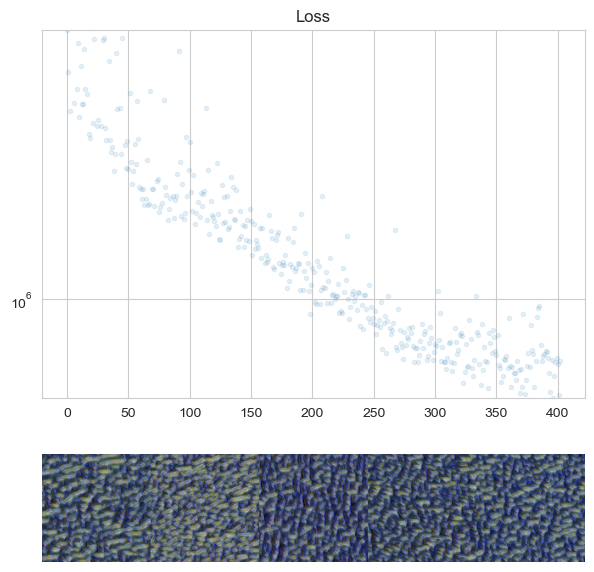

In [ ]:
EPOCHS = 4000
BATCH_SIZE = 5

t_img = deepcopy(img)
t_img = t_img.resize((RES, RES), PIL.Image.ANTIALIAS)
target = torch.FloatTensor(np.float32(t_img)[:, :, :3]/255.0).cuda().permute(2, 0, 1).unsqueeze(0)

fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

with torch.no_grad():
  loss_f = create_vgg_loss(target)

imgs = []
loss_log = []
grad_log = []

state = ca_train.seed(n=BATCH_SIZE, RES=RES)

for epoch in range(EPOCHS):
    optim.zero_grad()
    timeSteps = np.random.randint(32, 96)
    
    pool_idx = np.random.choice(len(pool), BATCH_SIZE, replace=False)
    state = pool[pool_idx].to(device='cuda')
    if epoch%8==0:
        state[:1] = ca_train.seed(n=1, RES=RES).to('cuda')  # some batches still have random seed
    
    for i in range(timeSteps):
        state = ca_train.forward_perception(state, dt=1)
    
    loss = loss_f(to_rgb(state)) + overflow_loss(state)
    
    loss_log.append(loss.item())
    
    with torch.no_grad():
        loss.backward()
        for p in ca_train.parameters():
            if p.grad is not None:
                p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 

    pool[pool_idx] = state.detach().cpu()  # update sample pool 
    
    optim.step()
    lr_sched.step()
    
    nx = to_rgb(state).permute([0, 2, 3, 1])[0].detach().cpu().numpy()
    imgs.append(nx)
    
    if i % 5 == 0:
        try:            
            print('plotting')
            # Create the large plot on top
            ax_main = fig.add_subplot(gs[0])
            ax_main.plot(loss_log, '.', alpha=0.1)
            ax_main.set_yscale('log')
            ax_main.set_ylim(np.min(loss_log), loss_log[0])
            ax_main.set_title('Loss')
            
            # Create the small plot on the bottom
            ax_images = fig.add_subplot(gs[1])
            imgs_out = to_rgb(state).permute([0, 2, 3, 1]).detach().cpu()
            imgs_out = np.uint8(np.clip(imgs_out, 0, 1) * 255)
            
            ax_images.imshow(np.concatenate([im for im in imgs_out], axis=1))
            ax_images.axis('off')
            
            
            display(plt.gcf())
            clear_output(wait=True)
            time.sleep(1.0)
            plt.clf()
        except KeyboardInterrupt:
            break 

In [ ]:
# Save the model
torch.save(ca_train.state_dict(), f'../figures/trained_NCA/CA_vgg16_{target_file[:-4]}.pth')

In [ ]:
imgs_out = to_rgb(state).permute([0, 2, 3, 1]).detach().cpu()
imshow(np.hstack(imgs_out), id='batch')

### Save the video from training

In [ ]:
import os 

fname = time.strftime("%Y%m%d-%H%M%S")
video_dir = '../figures/trained_NCA/videos'
video_path = os.path.join(video_dir, f'CA-{fname}-training.avi')

# Use a more universally compatible codec like MJPG
codec = cv2.VideoWriter_fourcc(*'MJPG')
fps = 60
resolution = (RES, RES)  # Make sure RES is defined and matches your image resolution

# Initialize VideoWriter
vout = cv2.VideoWriter(video_path, codec, fps, resolution, 3)

if not vout.isOpened():
    print("Error: Could not open video writer")
else:
    for im in imgs:
        # Assuming 'imgs' is a list of numpy arrays in RGB format
        im_t = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        im_t = np.uint8(im_t * 255.)
        vout.write(im_t)

    vout.release()
    print(f'Video saved to {video_path}')

### Save a video of the latest model

In [ ]:
timesteps = 5000

imgs_b = []
with torch.no_grad():
    state = ca_train.seed(n=1, RES=RES).cuda()
    for i in tqdm(range(timesteps)):
        state = ca_train.forward_perception(state, dt=1, update_rate=0.5)
        # nx = state[0, 0:3].cpu().numpy().transpose(1, 2, 0)
        nx = to_rgb(state).permute([0, 2, 3, 1])[0].detach().cpu().numpy()
        nx = np.clip(nx, 0, 1)
        imgs_b.append(nx)

plt.imshow(imgs_b[-1])

# Save a few frames as an image

In [ ]:
# save the last frame as an upscaled image
fname = time.strftime("%Y%m%d-%H%M%S")
img_dir = '..figures/trained_NCA'


for frame in [-1, -1000, -2000, -3000]:
    img = PIL.Image.fromarray(np.uint8(imgs_b[frame]*255))
    img_path = os.path.join(img_dir, f'CA-{fname}-trained_{frame}.jpg')
    #upscale the image
    img = img.resize((256, 256), PIL.Image.ANTIALIAS)
    img.save(img_path)


In [ ]:
import os 

fname = time.strftime("%Y%m%d-%H%M%S")
video_path = os.path.join(video_dir, f'CA-{fname}-trained.avi')

# Use a more universally compatible codec like MJPG
codec = cv2.VideoWriter_fourcc(*'MJPG')
fps = 60
resolution = (RES, RES)  # Make sure RES is defined and matches your image resolution

# Initialize VideoWriter
vout = cv2.VideoWriter(video_path, codec, fps, resolution, 3)

if not vout.isOpened():
    print("Error: Could not open video writer")
else:
    for im in imgs_b:
        # Assuming 'imgs' is a list of numpy arrays in RGB format
        im_t = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        im_t = np.uint8(im_t * 255.)
        vout.write(im_t)

    vout.release()
    print(f'Video saved to {video_path}')